In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import scipy
import requests
from matplotlib.patches import Rectangle
from datetime import datetime
# sns.set()

# Introduction <a id='intro'></a>

This notebook cleans and wrangles numerous data sets, making them uniform
so that they can be used in a data-driven model for COVID-19 prediction.

The key cleaning measures are those which find the most viable set of countries and date ranges
such that the maximal amount of data can be used. In other words, different datasets can have data
on a different set of countries; to avoid introducing large quantities of missing values
the intersection of these countries is taken. For the date ranges, depending on the quantity,
extrapolation/interpolation is used to ensure that each time series is defined to be non-zero
on all dates. 


# Table of contents<a id='toc'></a>

## [Data wrangling function definitions](#generalfunctions)

# Data <a id='data'></a>

            -->
## [JHU CSSE case data.](#csse)
[https://systems.jhu.edu/research/public-health/ncov/](https://systems.jhu.edu/research/public-health/ncov/)

**Data available at:**
[https://github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

This data is split between a collection of .csv files of two different formats; first, the daily reports (global) are
separated by day, each residing in their own .csv. Additionally, the daily report files have three different formats that need to be taken into account when compiling the data. The daily report data itself contains values on the number of confirmed cases, deceased, active cases, recovered cases.

For the other format, .csv files with 'timeseries' in their filename, the data contains values for confirmed, deceased, recovered and are split between global numbers (contains United States as a whole) and numbers for the united states (statewide).
           
           
## [OWID case and test data](#owid)

**Data available via github**
[https://github.com/owid/covid-19-data](https://github.com/owid/covid-19-data)

[https://ourworldindata.org/covid-testing](https://ourworldindata.org/covid-testing)

The OWID dataset contains information regarding case and test numbers; it overlaps with the JHU CSSE 
and Testing Tracker datasets but I am going to attempt to use it in conjunction with those two because
of how there is unreliable reporting. In other words to get the bigger picture I'm looking to stitch together
multiple datasets.

           
## [OxCGRT government response data](#oxcgrt)

**Data available at:**
[https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv](https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv)


**If API used to pull data (I elect not to because the datasets are different)**
[https://covidtracker.bsg.ox.ac.uk/about-api](https://covidtracker.bsg.ox.ac.uk/about-api)

The OxCGRT dataset contains information regarding different government responses in regards to social
distancing measures. It measures the type of social distancing measure, whether or not they are recommended
or mandated, whether they are targeted or broad (I think geographically). 
           
## [Testing tracker data](#testtrack)
<!-- **Website which lead me to dataset**
[https://www.statista.com/statistics/1109066/coronavirus-testing-in-europe-by-country/](https://www.statista.com/statistics/1109066/coronavirus-testing-in-europe-by-country/) -->

**Data available at:**
[https://finddx.shinyapps.io/FIND_Cov_19_Tracker/](https://finddx.shinyapps.io/FIND_Cov_19_Tracker/)

This dataset contains a time series of testing information: e.g. new (daily) tests, cumulative tests, etc. 


# [Data regularization: making things uniform](#uniformity)

### [Intersection of countries](#country)
  
### [Time series date ranges](#time)

### [Missing Values](#missingval)

## Data wrangling function declaration <a id='generalfunctions'></a>


In [2]:
def reformat_values(values_to_transform, category='columns',dateformat=None):
    """ Reformat column and index names. 
    
    Parameters :
    ----------
    df : Pandas DataFrame
    columns : bool
    index : bool|
    
    Notes :
    -----
    Change headers of columns; this needs to be updated to account for their formatting changes. 
    This function converts strings with CamelCase, underscore and space separators to lowercase words uniformly
    separated with underscores. I.e. (hopefully!) following the correct python identifier syntax so that each column
    can be reference as an attribute if desired. 

    For more on valid Python identifiers, see:
    https://docs.python.org/3/reference/lexical_analysis.html#identifiers
    """
    
    """ Reformat column and index names. only works with with pandas MultiIndex for level=0.
    
    Parameters :
    ----------
    df : Pandas DataFrame

    Notes :
    -----
    Different datasets have different naming conventions (for countries that go by multiple names and abbreviations).
    This function imposes a convention on a selection of these country names.  
    """
    # these lists are one-to-one. countries compared via manual inspection, unfortunately. 
    mismatch_labels_bad = ['Lao People\'s Democratic Republic', 'Mainland China',
                           'Occupied Palestinian Territory','Republic of Korea', 'Korea, South', 
                           'Gambia, The ', 'UK', 
                           'USA', 'Iran (Islamic Republic of)',
                           'Bahamas, The', 'Russian Federation', 'Czech Republic', 'Republic Of Ireland',
                          'Hong Kong Sar', 'Macao Sar', 'Uk','Us',
                           'Congo ( Kinshasa)','Congo ( Brazzaville)',
                           'Cote D\' Ivoire', 'Viet Nam','Guinea- Bissau','Guinea','Usa']

    mismatch_labels_good = ['Laos','China',
                            'Palestine', 'South Korea', 'South Korea', 
                            'The Gambia', 'United Kingdom', 
                            'United States','Iran',
                            'The Bahamas','Russia','Czechia','Ireland',
                            'Hong Kong','Macao','United Kingdom', 'United States',
                            'Democratic Republic Of The Congo','Republic Of The Congo',
                            'Ivory Coast','Vietnam', 'Guinea Bissau','Guinea Bissau','United States']
    
    # three cases, column names, country names, or datetime. 
    if category == 'location':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append(' '.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                        re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val).lower())
                                                        .split()).title())
        transformed_values = pd.Series(reformatted_values).replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)
    
    elif category == 'columns':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append('_'.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                     re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val)
                                                            .lower()).split()))
        transformed_values = pd.Series(reformatted_values)
        
    elif category == 'date':
        transformed_values = pd.to_datetime(pd.Series(
            values_to_transform), errors='coerce',format=dateformat).dt.normalize()


    return transformed_values

def clean_DataFrame(df):
    """ Remove all NaN or single value columns. 
    
    """
    # if 0 then column is all NaN, if 1 then could be mix of NaN and a
    # single value at most. 
    df = df.loc[:, df.columns[(df.nunique() > 0)]]
    return df

In [3]:
#----------------- Helper Functions for cleaning ----------------------#

def regularize_country_names(df):
    """ Reformat column and index names. only works with with pandas MultiIndex for level=0.
    
    Parameters :
    ----------
    df : Pandas DataFrame

    Notes :
    -----
    Different datasets have different naming conventions (for countries that go by multiple names and abbreviations).
    This function imposes a convention on a selection of these country names.  
    """
    # these lists are one-to-one. countries compared via manual inspection, unfortunately. 
    mismatch_labels_bad = ['Lao People\'s Democratic Republic', 'Mainland China',
                           'Occupied Palestinian Territory','Republic of Korea', 'Korea, South', 
                           'Gambia, The ', 'UK', 
                           'USA', 'Iran (Islamic Republic of)',
                           'Bahamas, The', 'Russian Federation', 'Czech Republic', 'Republic Of Ireland',
                          'Hong Kong Sar', 'Macao Sar', 'Uk','Us',
                           'Congo ( Kinshasa)','Congo ( Brazzaville)',
                           'Cote D\' Ivoire', 'Viet Nam','Guinea- Bissau','Guinea','Usa']

    mismatch_labels_good = ['Laos','China',
                            'Palestine', 'South Korea', 'South Korea', 
                            'The Gambia', 'United Kingdom', 
                            'United States','Iran',
                            'The Bahamas','Russia','Czechia','Ireland',
                            'Hong Kong','Macao','United Kingdom', 'United States',
                            'Democratic Republic Of The Congo','Republic Of The Congo',
                            'Ivory Coast','Vietnam', 'Guinea Bissau','Guinea Bissau','United States']
    if len(df.index.names) == 1:
        placeholder = df.index.name
        df = df.reset_index()
        df.loc[:,placeholder] = df.loc[:,placeholder].replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)
        print(len(df))
        df = df.drop_duplicates()
        print(len(df))
        df = df.set_index(placeholder)#.sum()
    else:
        placeholder = df.index.names[0]
        df = df.reset_index(level=0)
        df.loc[:,placeholder] = df.loc[:,placeholder].replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)
        print(len(df))
        df = df.drop_duplicates()
        print(len(df))
        df = df.set_index([placeholder, df.index])
    return df

#----------------- Helper Functions for regularization ----------------------#
def intersect_country_index(df, country_intersection):
    df_tmp = df.copy().reset_index(level=0)
    df_tmp = df_tmp[df_tmp.location.isin(country_intersection)]
    df_tmp = df_tmp.set_index(['location', df_tmp.index])
    return df_tmp 

def resample_dates(df, dates):
    df = df.loc[~df.index.duplicated(keep='first')]
    return df.reindex(pd.MultiIndex.from_product([df.index.levels[0], dates], names=['location', 'date']), fill_value=np.nan)

def make_multilevel_columns(df):
    df.columns = pd.MultiIndex.from_product([[df.columns.name], df.columns], names=['dataset', 'features'])
    return df

def multiindex_to_table(df):
    df_table = df.copy()
    try:
        df_table.columns = df_table.columns.droplevel()
        df_table.columns.names = ['']
    except:
        pass
    df_table = df_table.reset_index()
    return df_table

#----------------- Manipulation flagging ----------------------#


def regularize_names(df, datekey=None, locationkey=None, dateformat=None):
    df.columns = reformat_values(df.columns, category='columns').values
    if datekey is not None:
        df.loc[:, 'date'] = reformat_values(df.loc[:, datekey], category='date', dateformat=None).values
    if locationkey is not None:
        df.loc[:, 'location'] =  reformat_values(df.loc[:, locationkey], category='location').values
    return df



def add_time_indices(data_table, index_column='cases'):
    indexer = data_table.loc[:, ['location', index_column]].replace(to_replace=0, value=np.nan).dropna().reset_index()
    country_groupby_indices = country_groupby(data_table)
    country_groupby_indices_dropped_nan = country_groupby(indexer)
    days_since = []
    for i, c in enumerate(country_groupby_indices_dropped_nan):
        nonzero_list = list(range(len(c)))
        zero_list = 0*np.array(list(range(len(country_groupby_indices[i])-len(c))))
        days_since += list(zero_list)+nonzero_list

    data_table.loc[:, 'days_since_first_case'] = days_since
    data_table.loc[:, 'time_index'] = len(data_table.location.unique())*list(range(len(data_table.date.unique())))
    return data_table


def regularize_time_series(df_list):
    country_intersection = df_list[0].index.levels[0].unique()
    dates_union =  df_list[0].index.levels[1].unique()
    dates_intersection =  df_list[0].index.levels[1].unique()

    for i in range(len(df_list)-1):
        country_intersection = country_intersection.intersection(df_list[i+1].index.levels[0].unique())
        dates_union = dates_union.union(df_list[i+1].index.levels[1].unique())
        # not really intersection, this is the minimum date that at least one country has data for, in each dataset.
        dates_intersection = dates_intersection.intersection(df_list[i+1].index.levels[1].unique())

    df_list_intersected = [intersect_country_index(df, country_intersection) for df in df_list]

    #This redefines the time series for all variables as from December 31st 2019 to the day with most recent data
    time_normalized_global_data = [resample_dates(df, dates_intersection.normalize()) for df in df_list_intersected]
    # To keep track of which data came from where, make the columns multi level with the first level labelling the dataset.
    return time_normalized_global_data, dates_intersection, country_intersection


def rolling_means(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = None
        for c in country_groupby(df):
            if rollmean is None:
                rollmean = df.loc[c, features].rolling(window).mean().fillna(value=0.)
            else:
                rollmean = pd.concat((rollmean,  df.loc[c,features].rolling(window).mean().fillna(value=0.)),axis=0)
#         rollmean = pd.DataFrame(df..groupby(by='location').rolling(window).mean().fillna(value=0.))
#         rollstd = pd.DataFrame(df.groupby(by='location').rolling(window).std().fillna(value=0.))    
#         new_features = pd.concat((rollmean, rollstd), axis=1)
        new_features = rollmean
        new_cols = pd.Index(features) +'_rolling_mean_' + str(window)
#         rsind = features +'_rolling_std_' + str(window)
#         new_cols = rmind.append(rsind)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return new_feature_df_list


def rolling_features(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = None
        rollstd = None
        for c in country_groupby(df):
            if rollmean is None:
                rollmean = df.loc[c, features].rolling(window).mean().fillna(value=0.)
                rollstd = df.loc[c, features].rolling(window).std().fillna(value=0.)
            else:
                rollmean = pd.concat((rollmean,  df.loc[c,features].rolling(window).mean().fillna(value=0.)),axis=0)
                rollstd = pd.concat((rollstd,  df.loc[c,features].rolling(window).std().fillna(value=0.)),axis=0)

        new_features = pd.concat((rollmean, rollstd), axis=1)
#         new_features = rollmean
#         new_cols = pd.Index(features) +'_rolling_mean_' + str(window)
#         new_cols = mean_cols

        mean_cols = pd.Index(features) +'_rolling_mean_' + str(window)
        std_cols = pd.Index(features) +'_rolling_std_' + str(window)
        new_cols = mean_cols.append(std_cols)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return new_feature_df_list



def tsplot(pd_series, roll_width, **kw):
    fig, ax = plt.subplots(figsize=(10,5))
    rollmean = pd_series.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
    rollstd  = pd_series.rolling(roll_width).std().fillna(method='backfill').values.ravel()
    cis = (rollmean - rollstd, rollmean + rollstd)
    ax.fill_between(range(len(pd_series)), cis[0], cis[1], alpha=0.5)
    ax.plot(range(len(pd_series)), rollmean, color='k')
    return ax



def regularize_names(df, datekey=None, locationkey=None, dateformat=None):
    df.columns = reformat_values(df.columns, category='columns').values
    if datekey is not None:
        df.loc[:, 'date'] = reformat_values(df.loc[:, datekey], category='date', dateformat=None).values
    if locationkey is not None:
        df.loc[:, 'location'] =  reformat_values(df.loc[:, locationkey], category='location').values
    return df

def drop_all_but_least_missing(df, feature):
    matching_columns = column_search(df, feature, return_style='iloc', threshold='match') 
    feature_index =  matching_columns[df.iloc[:, matching_columns].isna().sum().argmin()]


def country_search(df, country):
    return df[df.location==country].index

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]


def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

# def fix_incorrect_decrease(df, feature, search_threshold='match'):
#     matching_columns = column_search(df, feature, return_style='iloc', threshold=search_threshold) 
#     feature_index =  matching_columns[df.iloc[:, matching_columns].isna().sum().argmin()]
#     location_index =  column_search(df, 'location', return_style='iloc', threshold=search_threshold)[0] 
#     print('Fixing the {} column feature'.format(df.iloc[:, feature_index].name))
#     # premptive filling, not related to decreasing but rather missing values.
#     decreasing_incorrectly = []
#     flag = True
#     # flag is switched off immediately, but will be switched on if any values are changed.
#     df.iloc[:, feature_index] = df.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
#     df.iloc[:, feature_index] = df.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
#     while flag:
#         flag = False
#         decreasing_indices = np.where(df.iloc[:, [location_index, feature_index]].groupby('location').diff(1)< 0)[0].ravel()
#         if decreasing_indices.size > 0:
#             countries_with_missing = df.iloc[decreasing_indices, location_index].unique().tolist()
#             flag = True
#             df.iloc[decreasing_indices, feature_index] = np.nan
#             df.iloc[:, feature_index] = df.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
#             df.iloc[:, feature_index] = df.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
#     return None

In [4]:
def fix_incorrect_decrease(df, feature, search_threshold='match'):
    df_tmp = df.copy()
    matching_columns = column_search(df_tmp, feature, return_style='iloc', threshold=search_threshold) 
    feature_index =  matching_columns[df_tmp.iloc[:, matching_columns].isna().sum().argmin()]
    location_index =  column_search(df_tmp, 'location', return_style='iloc', threshold=search_threshold)[0] 
    decreasing_indices = np.where(df_tmp.iloc[:, [location_index, feature_index]].groupby('location').diff(1)< 0)[0].ravel()
    n_countries_with_missing = len(df_tmp.iloc[decreasing_indices, location_index].unique().tolist())
    print('Fixing {} countries in the ''{}'' column feature'.format(
        n_countries_with_missing, df_tmp.iloc[:, feature_index].name)) 
    # premptive filling, not related to decreasing but rather missing values.
    decreasing_incorrectly = []
    flag = True
    
    # flag is switched off immediately, but will be switched on if any values are changed.
    df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
    df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
    while flag:
        flag = False
        decreasing_indices = np.where(df_tmp.iloc[:, [location_index, feature_index]].groupby('location').diff(1)< 0)[0].ravel()
        if decreasing_indices.size > 0:
            countries_with_missing = df_tmp.iloc[decreasing_indices, location_index].unique().tolist()
            flag = True
            df_tmp.iloc[decreasing_indices, feature_index] = np.nan
            df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
            df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
    return df_tmp

In [5]:
df_list = []

#the actual format difference is being covered up by pd.concat which fills with Nans
for x in glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/*.csv'):
    tmp_df = pd.read_csv(x)
    tmp_df.columns = reformat_values(tmp_df.columns, category='columns').values
#     df = column_or_index_string_reformat(pd.read_csv(x),columns=True,index=False)
    df_list.append(tmp_df)

daily_reports_df = pd.concat(df_list, axis=0)
daily_reports_df.columns = reformat_values(daily_reports_df.columns, category='columns').values
daily_reports_df.loc[:, 'date'] = reformat_values(daily_reports_df.loc[:, 'last_update'], category='date').values
daily_reports_df.loc[:, 'location'] =  reformat_values(daily_reports_df.loc[:, 'country_region'], category='location').values

In [6]:
daily_reports_df.loc[:, 'combined_key'] = (daily_reports_df.province_state.astype('str').replace(to_replace='nan', value='')+' '+ daily_reports_df.location.astype('str')).values

In [7]:
daily_reports_df = daily_reports_df.drop(columns=['province_state', 'last_update', 'fips', 'admin2']).set_index(['location','date'])
#daily_reports_df = daily_reports_df.groupby(['location','date']).sum()

In [8]:
daily_reports_df.sample(5)

country_region  confirmed  deaths  recovered  \
location      date                                                      
United States 2020-06-11             US       99.0    14.0        0.0   
              2020-04-04             US      122.0     3.0        0.0   
              2020-03-26             US        1.0     0.0        0.0   
              2020-05-08             US       50.0     4.0        0.0   
              2020-05-30             US       28.0     0.0        0.0   

                          latitude  longitude        lat       long  active  \
location      date                                                            
United States 2020-06-11       NaN        NaN  41.020949 -84.133611    85.0   
              2020-04-04       NaN        NaN  42.324512 -88.452482     0.0   
              2020-03-26       NaN        NaN  33.176597 -98.687909     0.0   
              2020-05-08       NaN        NaN  33.478519 -82.482528    46.0   
              2020-05-30       NaN        NaN  29.944142 -98.711359    28.0   

                                    combined_key  incidence_rate  \
location      date                                                 
United States 2020-06-11      Ohio United States      292.371755   
              2020-04-04  Illinois United States             NaN   
              2020-03-26     Texas United States             NaN   
              2020-05-08   Georgia United States             NaN   
              2020-05-30     Texas United States       59.033122   

                          case-_fatality_ratio  
location      date                              
United States 2020-06-11             14.141414  
              2020-04-04                   NaN  
              2020-03-26                   NaN  
              2020-05-08                   NaN  
              2020-05-30              0.000000

## Data Reformatting

The following sections take the corresponding data set and reformat them such that the data
is stored in a pandas DataFrame with a multiindex; level=0 -> 'location' (country or region) and
level=1 -> date. Due to the nature of the data this is done separately for country-wide and united states-wide locations.

## JHU CSSE case data
<a id='csse'></a>
[Return to table of contents](#toc)

Tasks / to-do for this data set.

In [9]:
global_df_list = []

for x in glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_time_series/*_global.csv'):
    tmp_df = pd.read_csv(x)
    catcols = tmp_df.iloc[:, :4]
    datecols = tmp_df.iloc[:, 4:]
    catcols.columns = reformat_values(catcols.columns, category='columns').values
    catcols.loc[:, 'location'] =  reformat_values(catcols.loc[:, 'country_region'], category='location').values
    datecols.columns = reformat_values(datecols.columns, category='date').values
    global_tmp = pd.concat((catcols.location,datecols),axis=1).groupby(by='location').sum().sort_index()
    # keep the name of the data; i.e. 'confirmed', 'deaths', etc.
    time_series_name = x.split('.')[0].split('_')[-2]
    global_df_list.append(global_tmp.stack().to_frame(name=time_series_name))



csse_global_time_series_df = pd.concat(global_df_list, axis=1)#.reset_index(drop=True)
csse_global_time_series_df.index.names = ['location','date']
csse_global_time_series_df.columns.names = ['csse_global_timeseries']
csse_global_time_series_df.columns = ['cases', 'deaths', 'recovered']

In [10]:
csse_global_time_series_df.sample(5)

,,cases,deaths,recovered
location,date,,,
Suriname,2020-02-12 00:00:00,0,0,0
Cabo Verde,2020-02-05 00:00:00,0,0,0
Western Sahara,2020-03-13 00:00:00,0,0,0
Kyrgyzstan,2020-05-10 00:00:00,1002,12,675
Czechia,2020-03-04 00:00:00,8,0,0


In [11]:
usa_df_list = []
for x in glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_time_series/*_US.csv'):
    tmp_df = pd.read_csv(x)
    catcols = tmp_df.iloc[:, :np.where(tmp_df.columns == '1/22/20')[0][0]]
    catcols.columns = reformat_values(catcols.columns, category='columns').values
    catcols.loc[:, 'location'] =  catcols.loc[:, 'province_state'].values
    
    datecols = tmp_df.iloc[:,np.where(tmp_df.columns == '1/22/20')[0][0]:]
    datecols.columns = reformat_values(datecols.columns, category='date').values
    usa_tmp = pd.concat((catcols.location,datecols),axis=1).groupby(by='location').sum().sort_index()
    # keep the name of the data; i.e. 'confirmed', 'deaths', etc.
    time_series_name = x.split('.')[0].split('_')[-2]
    usa_df_list.append(usa_tmp.stack().to_frame(name=time_series_name))
    
usa_time_series_df = pd.concat(usa_df_list,axis=1)#.reset_index(drop=True)
usa_time_series_df.index.names = ['location','date']
usa_time_series_df.columns.names = ['csse_us_timeseries']


In [12]:
usa_time_series_df.sample(5)

,csse_us_timeseries,confirmed,deaths
location,date,,
North Carolina,2020-03-06 00:00:00,2,0
Virginia,2020-06-07 00:00:00,50681,1472
Iowa,2020-05-01 00:00:00,7884,170
Grand Princess,2020-03-31 00:00:00,103,3
South Dakota,2020-04-09 00:00:00,447,6


## OWID case and test data
<a id='source5'></a>
[Return to table of contents](#toc)

The "Our World in Data" dataset contains time series information on the cases, tests, and deaths.

In [13]:
owid_df =pd.read_csv('./covid-19-data/public/data/owid-covid-data.csv')
# owid_df= owid_df[owid_df.new_cases_per_million > 0])#.new_cases_per_thousand.
owid_df = regularize_names(owid_df, datekey='date', locationkey='location').set_index(['location', 'date']).sort_index()

In [14]:
owid_df.sample(5)

,,iso_code,continent,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
location,date,,,,,,,,,,,,,,,,,,,,,
Russia,2020-05-30,RUS,Europe,387623.0,8572.0,4374.0,232.0,2656.144,58.739,29.972,1.590,...,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58
Chad,2020-05-27,TCD,Africa,700.0,13.0,62.0,1.0,42.616,0.791,3.775,0.061,...,1.446,1768.153,38.4,280.995,6.10,NaN,NaN,5.818,NaN,54.24
Zimbabwe,2020-04-30,ZWE,Africa,34.0,2.0,4.0,0.0,2.288,0.135,0.269,0.000,...,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.70,61.49
Democratic Republic Of Congo,2020-06-11,COD,Africa,4389.0,131.0,95.0,6.0,49.005,1.463,1.061,0.067,...,1.745,808.133,77.1,318.949,6.10,NaN,NaN,4.472,NaN,60.68
Burkina Faso,2020-05-17,BFA,Africa,782.0,0.0,51.0,0.0,37.410,0.000,2.440,0.000,...,1.358,1703.102,43.7,269.048,2.42,1.6,23.9,11.877,0.40,61.58


## OxCGRT government response data
<a id='oxcgrt'></a>
[Return to table of contents](#toc)

Manual importation of data (for whatever reason this data set is different from pulling using API). This
dataset contains time series information for the different social distancing and quarantine measures. The time
series are recorded using flags which indicate whether or not a measure is in place, recommended, or not considered.
In addition, there are addition flags which augment these time series; indicating whether or not the measures are targeted
or general.

In [15]:
oxcgrt_df = regularize_names(pd.read_csv('OxCGRT_latest.csv'), locationkey='country_name')
oxcgrt_df.loc[:, 'date'] = pd.to_datetime(oxcgrt_df.loc[:, 'date'], format='%Y%m%d')
oxcgrt_df = oxcgrt_df.set_index(['location', 'date'])
# oxcgrt_df = oxcgrt_df.drop(columns='m1_wildcard')

In [16]:
oxcgrt_df.stringency_index.nunique()

159

In [17]:
oxcgrt_df.sample(5)

,,country_name,country_code,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,c3_cancel_public_events,c3_flag,c4_restrictions_on_gatherings,c4_flag,...,stringency_index,stringency_index_for_display,stringency_legacy_index,stringency_legacy_index_for_display,government_response_index,government_response_index_for_display,containment_health_index,containment_health_index_for_display,economic_support_index,economic_support_index_for_display
location,date,,,,,,,,,,,,,,,,,,,,,
Panama,2020-03-03,Panama,PAN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,8.33,8.33,13.10,13.10,5.77,5.77,6.82,6.82,0.0,0.0
United Kingdom,2020-03-07,United Kingdom,GBR,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,11.11,11.11,14.29,14.29,17.95,17.95,21.21,21.21,0.0,0.0
Indonesia,2020-05-17,Indonesia,IDN,3.0,1.0,3.0,0.0,2.0,0.0,4.0,0.0,...,74.54,74.54,79.29,79.29,58.01,58.01,68.56,68.56,0.0,0.0
Georgia,2020-05-08,Georgia,GEO,3.0,1.0,2.0,1.0,2.0,1.0,4.0,1.0,...,96.30,96.30,96.43,96.43,85.26,85.26,93.94,93.94,37.5,37.5
Belize,2020-05-13,Belize,BLZ,3.0,1.0,1.0,0.0,2.0,1.0,3.0,1.0,...,71.30,71.30,75.00,75.00,63.46,63.46,70.45,70.45,25.0,25.0


Reformat the data, making it a multiindex dataframe which matches the others in this notebook. Also, cast
the date-like variable as a datetime feature.

## Testing tracker data
<a id='testtrack'></a>
[Return to table of contents](#toc)

This dataset only pertains to testing data of different locations. 

In [18]:
testtracker_cases = regularize_names(pd.read_csv('test_tracker_cases.csv'),
                          datekey='date', locationkey='country').set_index(
                            ['location', 'date']).drop(
                                    columns=['population','country','alpha3']).sort_index()

In [19]:
testtracker_cases.sample(3)

,,cases,new_cases,deaths,cases_per100k,deaths_per100k,income_group,continent,region
location,date,,,,,,,,
Bangladesh,2020-06-12,81523,3471,1095,49.5,0.7,Lower middle income,Asia,Southern Asia
Ukraine,2020-03-29,475,119,10,1.1,0.0,Lower middle income,Europe,Eastern Europe
Taiwan,2020-03-29,298,15,2,1.3,0.0,High income,Asia,Eastern Asia


In [20]:
testtracker_tests = regularize_names(pd.read_csv('test_tracker_tests.csv'),
                          datekey='date', locationkey='country').set_index(['location', 'date']).drop(
                                    columns=['population','country','source','alpha3']).iloc[:,:-3].sort_index()

In [21]:
testtracker_tests.sample(3)

,,new_tests,tests_cumulative,tests_per100k
location,date,,,
Lesotho,2020-05-04,0,7,0.3
Romania,2020-04-14,2893,70097,364.4
Central African Republic,2020-06-01,0,15021,311.0


## Data regularization: making things uniform <a id='uniformity'></a>

## Intersection of countries in all DataFrames
<a id='country'></a>
[Return to table of contents](#toc)

The data that will be used to model country-wide case numbers exists in the DataFrames : 

    csse_global_daily_reports_df
    csse_global_timeseries_df
    owid_df
    oxcgrt_df
    testtrack_df
    
The index (locations) were not reformatted by default; do that now.

The data have all been formatted to have multi level indices and columns; the levels of the index are ```['location', 'date']``` which correspond to geographical location and day of record. I find it convenient to put these DataFrames into
an iterable (list specifically).

In [22]:
global_data = [csse_global_time_series_df, testtracker_cases,
               testtracker_tests, oxcgrt_df, owid_df]

The first step is to correct the differences in naming conventions so that equivalent countries in fact have the same labels.

The next step is to find the subset of all countries which exist in all of the DataFrames. It is possible to
simply concatenate the data and introduce missing values, however, I am electing to take the intersection of countries as
to take the most "reliable" subset. On the contrary, for the dates I take the union; that is, the dates that exist in all datasets. 

# Data preprocessing and exploration

In [23]:
names = ['jhucsse','ttc', 'ttt',  'oxcgrt', 'owid']
export_list = []

export_list_tmp, dates_intersection, country_intersection = regularize_time_series(global_data)
print('The range of all dates is from {} to {}'.format(dates_intersection.min(), dates_intersection.max()))
print('The final number of countries included is {}'.format(len(country_intersection)))

for i, x in enumerate(export_list_tmp):
    gd_export_copy = x.copy()
    gd_export_copy.columns += '_' + names[i]
    export_list.append(gd_export_copy)

eda_data = multiindex_to_table(pd.concat(export_list, axis=1))
eda_data = add_time_indices(eda_data, index_column='cases_jhucsse')
eda_data.to_csv('eda_data.csv')

The range of all dates is from 2020-01-22 00:00:00 to 2020-06-12 00:00:00
The final number of countries included is 140


In [24]:
dataframe_list, modeling_dates, modeling_countries = regularize_time_series(global_data)
print('The range of all dates is from {} to {}'.format(modeling_dates.min(), modeling_dates.max()))
print('The number of countries included is {}'.format(len(modeling_countries)))
# Convert the multiindex DataFrame to a simple table, and then add numerical features which track the
# date and # of days since first case. 
df = add_time_indices(multiindex_to_table(pd.concat(dataframe_list, axis=1)), index_column='cases')

The range of all dates is from 2020-01-22 00:00:00 to 2020-06-12 00:00:00
The number of countries included is 140


To show why these features need to be fixed in order to be cumulative. 

In [25]:
cumulative_columns = pd.Index(column_search(df, 'cases').unique().tolist()
                      +column_search(df, 'deaths').unique().tolist()
                      +column_search(df, 'tests').unique().tolist()+['recovered'])
cumulative_columns = cumulative_columns[~cumulative_columns.str.contains('new')].drop('tests_units')
cumulative_columns

Index(['cases', 'cases_per100k', 'confirmed_cases', 'total_cases',
       'total_cases_per_million', 'deaths', 'deaths_per100k',
       'confirmed_deaths', 'total_deaths', 'total_deaths_per_million',
       'tests_cumulative', 'tests_per100k', 'total_tests',
       'total_tests_per_thousand', 'recovered'],
      dtype='object')

Time series for these four countries, before any manipulations.

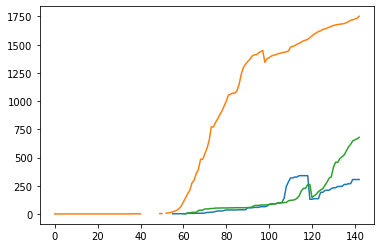

In [26]:
fig, ax = plt.subplots()
ax.plot(df[df.location == 'Benin'].total_cases.values)
ax.plot(df[df.location == 'Lithuania'].total_cases.values)
ax.plot(df[df.location == 'Uganda'].total_cases.values)

In [27]:
countries_with_total_cases_incorrect = df[(df.set_index([df.time_index, df.location]).loc[:, cumulative_columns
                                              ].groupby(level=1).diff(1).fillna(0) < 0).total_cases.values].location.unique()#.sum()

In [28]:
(df.set_index([df.time_index, df.location]).loc[:, cumulative_columns
                                              ].groupby(level=1).diff(1).fillna(0) < 0).sum()#.drop_duplicates()

cases                       30
cases                       30
cases_per100k               24
confirmed_cases             13
total_cases                 13
total_cases_per_million     13
deaths                      22
deaths                      22
deaths_per100k              11
confirmed_deaths             2
total_deaths                 0
total_deaths_per_million     0
tests_cumulative            12
tests_per100k               12
total_tests                  5
total_tests_per_thousand     5
recovered                   39
dtype: int64

In [29]:
for features in cumulative_columns:
    df = fix_incorrect_decrease(df, features, search_threshold='match')


Fixing 19 countries in the cases column feature
Fixing 15 countries in the cases_per100k column feature
Fixing 9 countries in the confirmed_cases column feature
Fixing 9 countries in the total_cases column feature
Fixing 9 countries in the total_cases_per_million column feature
Fixing 17 countries in the deaths column feature
Fixing 9 countries in the deaths_per100k column feature
Fixing 2 countries in the confirmed_deaths column feature
Fixing 0 countries in the total_deaths column feature
Fixing 0 countries in the total_deaths_per_million column feature
Fixing 11 countries in the tests_cumulative column feature
Fixing 11 countries in the tests_per100k column feature
Fixing 2 countries in the total_tests column feature
Fixing 2 countries in the total_tests_per_thousand column feature
Fixing 31 countries in the recovered column feature


This is due to errors in reporting, I want to fix these issues before moving on.

## Regularization of time series dates
<a id='time'></a>
[Return to table of contents](#toc)

## Preprocessing: missing values, feature production, etc.
<a id='missingval'></a>
[Return to table of contents](#toc)

The next section is concerned with the handling and imputation of missing values. The key consideration is
to not contaminate the time series with information from the future. Because I am filling in the missing values here,
I will be flagging the original missing values and keeping these flags as new features. Before I can compute these new features I need to think ahead towards the modeling phase of this project, that is, to take into consideration the features which
are to be predicted.

Specifically, I will be modelling and predicting new case numbers.

# Regression data


# CNN data

In [30]:
df.population_density.nunique(), df.location.nunique()

(139, 140)

First, we need to figure out the units of the population densities, for consistency.

This aligns with the population density being in units of people / km^2, per Google search.

## Data quality related exploration

    Differences in reporting 
    differences in time series.


## COVID related exploration

    Death rate estimation. 
    testing vs cases vs deaths
    log-log plot for current growth trends
    bollinger bands
    Differences in government responses (early vs late)
    histogram of trending upwards, flat, downwards
    tools, different plots, correlation plots scatter matrix plots. 

Because I am aggregating a number of different data sets, there are multiple features describing the same quantities (number of cases, deaths, etc.). The quality of the different sources varies, which informs the decision as to which of these columns to keep. This will be explored in more detail later.

My original idea was to normalize using the population of each country but I'm unsure as to whether this is the best
idea; at least without another consideration. Using the population blindly results in micro-states and small countries
being weighted heavily. Now, either I can drop these countries or I can weight the features differently; with the population *density*. This accounts for population as well as how large the state is.

## Feature production, deciding on which features to use for modeling<a id='newfeatures'></a>

In [31]:
# redundant features; some features contain the same substring but are not redundant, hence the use of .difference()
redundant_death_columns = column_search(df, 'death').difference(['cvd_death_rate'])
redundant_test_columns = column_search(df, 'test').difference(['tests_units','h2_testing_policy'])
redundant_case_columns= column_search(df, 'cases')

Before any feature production or investigation, fix the incorrect decreases in these four important columns.

I want to normalize by population, so first I need to fill in the missing values introduced by time series regularization / extrapolation; an additional manipulation is required for population density, namely, the population density feature is missing information on a single country: Afghanistan.

In [32]:
# To prevent the SettingCopyWithSlice warning use loc, which needs index values, hence
# the application of this workaround function. 
df.loc[country_search(df, 'Afghanistan'), 'population_density'] = 154
df.loc[country_search(df, 'Kosovo'), 'population_density'] = 159
df.loc[country_search(df, 'South Sudan'), 'population_density'] = 20.3
df.loc[country_search(df, 'Guinea Bissau'), 'population'] = \
df.loc[country_search(df, 'Guinea Bissau'), 'population'].max()

df.loc[country_search(df, 'Guinea Bissau'), 'population_density'] = \
df.loc[country_search(df, 'Guinea Bissau'), 'population_density'].max()


for country_indices in country_groupby(df):
    df.loc[country_indices, ['population','population_density']] = \
    df.loc[country_indices,  ['population','population_density']].fillna(method='ffill').fillna(method='bfill').values 

df = df[df.population > df.population.quantile(0.1)]
per_million_population = df.population / 1000000.
population_density = df.population_density
world_pop = df[df.time_index==df.time_index.max()].population.sum()
percent_pop = df.population / world_pop

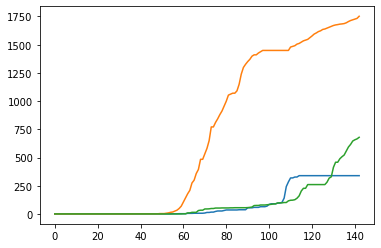

In [33]:
# df = fix_incorrect_decrease(df, 'total_cases', search_threshold='match')
fig, ax = plt.subplots()
ax.plot(df[df.location == 'Benin'].total_cases.values)
ax.plot(df[df.location == 'Lithuania'].total_cases.values)
ax.plot(df[df.location == 'Uganda'].total_cases.values)

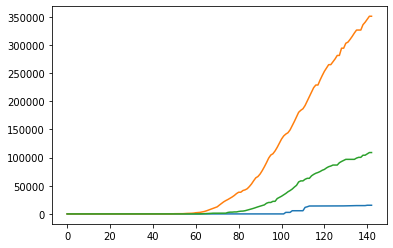

In [34]:
fig, ax = plt.subplots()
ax.plot(df[df.location == 'Benin'].tests_cumulative.values)
ax.plot(df[df.location == 'Lithuania'].tests_cumulative.values)
ax.plot(df[df.location == 'Uganda'].tests_cumulative.values)

Usage of custom function to fill in missing values, as well as check the validity of the time series. Mainly,
this means making sure that non-decreasing quantities in fact behave this way. It checks the difference between values $n$ and
$n+1$. If negative, the value at $n+1$ is replaced with the previous day's value. If this creates a new discrepancy, (i.e. $n+2$ is smaller then $n+1$ post-update, then it will be handled upon the next scan). Tried to make it as simple as possible to avoid any strange interactions; technically, the approximate slopes are calculated all at once and the values are updated all at once; instead of starting from the beginning and sweeping all the way through the time series. This approximation always propagates forwards, and by virtue of its calculation, always takes the larger value to be the truth. 

Time series post-corrections. 

Create and fill and fix new features. They are not currently weighted but they will be in the future, hence
the naming convention.

the problem

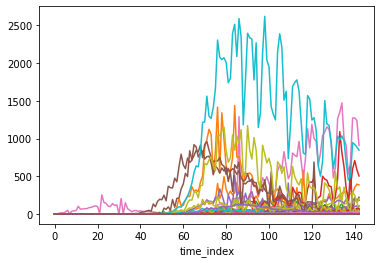

In [35]:
# for groupby later on
multi_deaths_temp = df.set_index(['time_index','location'])
# assuming that the best "deaths" reporting has least number of missing values.
ind = multi_deaths_temp.loc[:, column_search(multi_deaths_temp, 'deaths')].isna().sum().argmin()
# the best column with time, location multiindex. 
deaths_temp = multi_deaths_temp.iloc[:, column_search(multi_deaths_temp, 'deaths', return_style='iloc')[ind]]
deaths_temp.groupby(level=1).diff(1).fillna(0).unstack().plot(legend=False)

my solution: make the cumulative variable actually non-decreasing and then take the finite differences

New deaths is fine coming from ttt but I think even though owid has more missing values, that they are just zeros and so their new cases and new tests normalized should be used. 

owid data is good but populations are bad.



In [36]:
eda_data.loc[eda_data.new_cases_owid<0, 'new_cases_owid'] = 0
eda_data.loc[eda_data.new_tests_owid<0, 'new_tests_owid'] = 0
eda_data.loc[eda_data.new_deaths_owid<0, 'new_deaths_owid'] = 0

In [37]:
# Already have a good "new tests" feature, so do not need to compute differences
df.loc[:, 'new_tests_weighted'] = (eda_data.loc[df.index,'new_tests_owid'].fillna(0)/per_million_population).values

# Already have a good "new cases" feature, so do not need to compute differences
df.loc[:, 'new_cases_weighted'] =  (eda_data.loc[df.index,'new_cases_owid'].fillna(0)/per_million_population).values

# Create a number of deaths feature, there are multiple with the same name, hence the reason 'ind' is calculated
# for groupby later on

# # assuming that the best "deaths" reporting has least number of missing values.
# ind = multi_temp.loc[:, column_search(multi_temp, 'deaths')].isna().sum().argmin()
# # the best column with time, location multiindex. 
# deaths_temp = multi_temp.iloc[:, column_search(multi_temp, 'deaths', return_style='iloc')[ind]]
# corrected_deaths_temp = fix_incorrect_decrease(deaths_temp.reset_index(), 'deaths')
# death_values_to_weight = corrected_deaths_temp.set_index(['time_index', 'location']).groupby(level=1).diff(1).fillna(0)#.values
df.loc[:, 'new_deaths_weighted']  =  (eda_data.loc[df.index,'new_deaths_owid'].fillna(0) / per_million_population)

df = fix_incorrect_decrease(df, 'recovered')
df.loc[:, 'new_recovered_weighted'] = (df.set_index(['time_index','location']).recovered.groupby(
                                            level=1).diff(1).fillna(0).values / per_million_population.values)

Fixing 0 countries in the recovered column feature


In [38]:
df.loc[:, 'log_new_recovered_weighted'] = df.loc[:, 'new_recovered_weighted'].apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_deaths_weighted']  =  df.loc[:, 'new_deaths_weighted'] .apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_cases_weighted'] =  df.loc[:, 'new_cases_weighted'] .apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_tests_weighted'] = df.loc[:, 'new_tests_weighted'] .apply(lambda x: np.log(x+1))

Better data source seems to be test_tracker for tests and cases. Take recovered from JHUCSSE, tests,cases, and deaths from TestTracker.

For now just look at tests and cases. 

I believe that it is unwarranted to weight these countries with small populations so heavily as they comprise a tiny
fraction of the world population. However, it also seems unfair to divide by area (i.e. to get density) for countries
which have localized pockets of population. 

This next weighting "knows" about the global population and so it couples each country to all other countries.
I don't think this will cause any issues for the CNN in the modeling section but it might. It weights countries by
the percent of the world population which they constitute.

To reiterate my logic: I want or perhaps need to normalize the data. If I normalize simply on a "per million people" basis,
small micro-states such as San Marino will take on disproportionate values. I could drop these countries or look
for other weighting techniques; I opt for the latter method. The other two options I explore are weighting by population density, and weighting by the percentage of the world's population that each country comprises. The goal is to find a normalization which captures how hard individual countries have been hit but also the possible future downside, which
is of course is dependent upon how many people live in a country.

Also, the time-series of countries which have caught more cases overall will likely have better reporting practices and
be closer to the actual behavior of the virus transmission. Visual inspection of certain time series leads me to believe
they will simply act as noise, obfuscating the average or "actual" behavior. 

The current per capita weighting gives undue influence to microstate nations such as San Marino, as their population is
only a small fraction of 1 million. Therefore, remove the countries in the bottom 10 percent (arbitrary) of populations. 

Now that the new features with which to model are in place, remove the redundant and useless infomation.

Do I want to keep cumulative variables now that they are fixed???

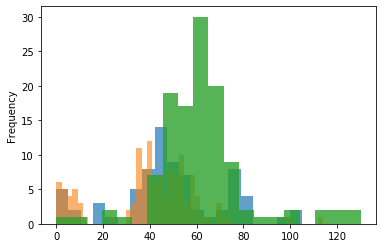

In [39]:
first_dates_temp = df.replace(to_replace=0., value=np.nan)
first_tests = df.loc[first_dates_temp.total_tests.dropna().index,:].groupby('location').time_index.min()
first_cases =  df.loc[first_dates_temp.total_cases.dropna().index,:].groupby('location').time_index.min()
first_deaths = df.loc[first_dates_temp.total_deaths.dropna().index,:].groupby('location').time_index.min()
first_tests.plot.hist(alpha=0.7, bins=20)
first_cases.plot.hist(alpha=0.6, bins=50)
first_deaths.plot.hist(alpha=0.8, bins=20)


In [40]:
df_pruned = df.drop(columns=(redundant_death_columns.tolist() 
                         + redundant_test_columns.tolist() 
                         + redundant_case_columns.tolist()+['recovered']))

In [41]:
assumed_to_be_better_stringency_index = df_pruned.loc[:, 'stringency_index'].isna().sum().argmin()
stringency = df_pruned.loc[:, 'stringency_index'].iloc[:, assumed_to_be_better_stringency_index]

df_pruned = df_pruned.drop(columns=['country_name', 'country_code',
                                                    'm1_wildcard','stringency_index_for_display',
                                                   'stringency_legacy_index', 'stringency_legacy_index_for_display',
                                                    'government_response_index_for_display',
                                                    'containment_health_index_for_display',
                                                    'economic_support_index_for_display',
                                                    'iso_code','stringency_index'])
df_pruned.loc[:, 'stringency_index'] = stringency.values

Personal preference of reordered the DataFrame; also helps with different missing value strategies later.

In [42]:
indexers = ['location','date','time_index','days_since_first_case']
new_weighted_quantity_features = ['new_cases_weighted',
            'new_tests_weighted', 
            'new_recovered_weighted', 
            'new_deaths_weighted']
log_new_weighted_quantity_features = ['log_new_cases_weighted',
            'log_new_tests_weighted', 
            'log_new_recovered_weighted', 
            'log_new_deaths_weighted']
flag_features = column_search(df_pruned,'flag')
time_independent_features =df_pruned.loc[:, 'population':'hospital_beds_per_thousand'].columns.tolist()
time_dependent_features = df_pruned.loc[:, 'c1_school_closing':'economic_support_index'].columns.difference(flag_features).tolist()+['stringency_index']
flag_features = flag_features.tolist()+['tests_units']

### **Custom fix for reporting zeros. **

In [43]:
# df_tmp = df_pruned.loc[:, new_weighted_quantity_features].replace(to_replace=0., value=np.nan)
# for country_indices in country_groupby(df):
#     df_tmp.loc[country_indices, :] = df_tmp.loc[country_indices, :].fillna(method='ffill').fillna(value=0)
# df_pruned.loc[:, new_weighted_quantity_features] = df_tmp.values

In [44]:
df_reorder = df_pruned.loc[:, indexers
                              +log_new_weighted_quantity_features
                              +new_weighted_quantity_features
                              +time_dependent_features
                              +time_independent_features
                              +flag_features]

The flag columns take values 1.0, 0.0, np.nan. 
Convert these to categorical, and for the sake of column names map floats to str.
Afterwards, drop the column that corresponds to missing values to remove collinearity. 

In [45]:
flag_df = df_reorder.loc[:, flag_features].fillna('Missing').astype('category')
for col in flag_df.columns:
    flag_df.loc[:, col] = flag_df.loc[:, col].cat.rename_categories({1.0 : '1', 0. : '0'})
    
flag_dummies = pd.get_dummies(flag_df)
flag_dummies_without_collinearity = flag_dummies[flag_dummies.columns[~flag_dummies.columns.str.contains('Missing')]]
df_reorder = pd.concat((df_reorder.drop(columns=flag_features),
                        flag_dummies_without_collinearity),axis=1)

Because I'm going to impute values for the time independent features, it may or may not be important to track this by flagging
the missing values via one-hot encoding. Note that I have just manipulated the flagging columns so that *their* missing value flags are not included; but again this is because of linear dependency reasons. 

For time independent features, do not have to be careful with time; because there is no two-sided fillna method that
I am aware of, handle this by filling forwards and backwards.

Time dependent features can only be filled forward so that information from the future is not visible from the past. Additionally, any other missing values are filled with 0's; only other options would be, for instance, the mean up to that date. 

In [46]:
# # for country_indices in country_groupby(df_reorder):
# df_reorder.loc[:, time_independent_features] = df_reorder.set_index(['time_index', 'location']).loc[:, time_independent_features].fillna(method='ffill').fillna(method='bfill')
# df_reorder.loc[:, time_dependent_features] = df_reorder.loc[:, time_dependent_features].fillna(method='ffill').fillna(value=0)
# # If I want to use the features which are still missing values, need to do something; including zeros seems wrong. 
# df_reorder.loc[:, time_independent_features] = df_reorder.loc[:, time_independent_features].fillna(df_reorder.loc[:, time_independent_features].median())
# df_reorder = regularize_names(df_reorder)
# df = df_reorder.copy()

In [47]:
missing_flags = df_reorder.iloc[:,np.where(df_reorder.isna().sum() > 0)[0]].isna().astype(int)
missing_flags.columns = missing_flags.columns + '_missing_flag'

In [48]:
missing_flags.sum()

c1_school_closing_missing_flag                          537
c2_workplace_closing_missing_flag                       570
c3_cancel_public_events_missing_flag                    563
c4_restrictions_on_gatherings_missing_flag              557
c5_close_public_transport_missing_flag                  564
c6_stay_at_home_requirements_missing_flag               537
c7_restrictions_on_internal_movement_missing_flag       542
c8_international_travel_controls_missing_flag           536
containment_health_index_missing_flag                   561
e1_income_support_missing_flag                          526
e2_debt_contract_relief_missing_flag                    542
e3_fiscal_measures_missing_flag                         711
e4_international_support_missing_flag                   566
economic_support_index_missing_flag                     575
government_response_index_missing_flag                  564
h1_public_information_campaigns_missing_flag            539
h2_testing_policy_missing_flag          

In [49]:
for country_indices in country_groupby(df_reorder):
    fill_tmp = df_reorder.loc[country_indices, time_independent_features].fillna(method='ffill').fillna(method='bfill')
    df_reorder.loc[country_indices, time_independent_features] = fill_tmp.values
    df_reorder.loc[country_indices, time_dependent_features] = df_reorder.loc[country_indices, time_dependent_features].fillna(method='ffill').fillna(value=0)
df_reorder.loc[:, time_independent_features] = df_reorder.loc[:, time_independent_features].fillna(df_reorder.loc[:, time_independent_features].median())
df = regularize_names(df_reorder).copy()

location_dummies_without_collinearity = pd.get_dummies(df.location, drop_first=True)
location_dummies_without_collinearity.columns += '_flag'
location_dummies_without_collinearity = regularize_names(location_dummies_without_collinearity)



# Feature production

In [50]:
def rolling_means(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = None
        for c in country_groupby(df):
            if rollmean is None:
                rollmean = df.loc[c, features].rolling(window).mean().fillna(value=0.)
            else:
                rollmean = pd.concat((rollmean,  df.loc[c,features].rolling(window).mean().fillna(value=0.)),axis=0)
#         rollmean = pd.DataFrame(df..groupby(by='location').rolling(window).mean().fillna(value=0.))
#         rollstd = pd.DataFrame(df.groupby(by='location').rolling(window).std().fillna(value=0.))    
#         new_features = pd.concat((rollmean, rollstd), axis=1)
        new_features = rollmean
        new_cols = pd.Index(features) +'_rolling_mean_' + str(window)
#         rsind = features +'_rolling_std_' + str(window)
#         new_cols = rmind.append(rsind)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return new_feature_df_list

In [51]:
np.array(time_dependent_features)

array(['c1_school_closing', 'c2_workplace_closing',
       'c3_cancel_public_events', 'c4_restrictions_on_gatherings',
       'c5_close_public_transport', 'c6_stay_at_home_requirements',
       'c7_restrictions_on_internal_movement',
       'c8_international_travel_controls', 'containment_health_index',
       'e1_income_support', 'e2_debt_contract_relief',
       'e3_fiscal_measures', 'e4_international_support',
       'economic_support_index', 'government_response_index',
       'h1_public_information_campaigns', 'h2_testing_policy',
       'h3_contact_tracing', 'h4_emergency_investment_in_healthcare',
       'h5_investment_in_vaccines', 'stringency_index'], dtype='<U37')

In [52]:
# Majority 
# time_dependent_features = list(np.array(time_dependent_features)[(df.loc[:, time_dependent_features].nunique() > 10).values])
# time_dependent_features

In [53]:
df.loc[:,column_search(df,'index')].columns[1:].tolist()

['containment_health_index',
 'economic_support_index',
 'government_response_index',
 'stringency_index']

In [54]:
oxcgrt_index_variables = df.loc[:,column_search(df,'index')].columns[1:].intersection(
                   pd.Index(time_dependent_features)).tolist()

In [55]:
model_df = df.loc[:, indexers 
                  + log_new_weighted_quantity_features
                  + new_weighted_quantity_features 
                  + oxcgrt_index_variables
                 ].copy()

In [56]:
new_features_list = rolling_means(model_df, log_new_weighted_quantity_features+new_weighted_quantity_features, roll_widths=[3])
new_features = pd.concat(new_features_list, axis=1)
# tmp = new_features.iloc[:,[0,1,2,3,-1,-7,-8,-13]]
# tmp.columns = [x[0] for x in tmp.columns.str.split('_rolling_mean_3')]
cnn_features =  (indexers 
                + log_new_weighted_quantity_features
                +new_weighted_quantity_features 
#                 + df.loc[:,column_search(df,'index')].columns[1:].tolist()
#                 +oxcgrt_index_variables
                )
               

cnn_df = model_df.loc[:, cnn_features] 
# smoothed_cnn_df = model_df.loc[:, cnn_features] 
# smoothed_cnn_df.loc[:, tmp.columns] = tmp.values

In [57]:
cnn_df.to_csv('cnn_datav2.csv')
# smoothed_cnn_df.to_csv('smoothed3_cnn_datav2.csv')

In [58]:
roll_widths = [7,14,21,28]
regression_df = df.loc[:, indexers 
                 + new_weighted_quantity_features 
#                  + oxcgrt_index_variables
                      ].copy()
new_features_list = rolling_means(regression_df, 
                                  new_weighted_quantity_features,
#                                   +oxcgrt_index_variables, 
                                  roll_widths=roll_widths)
new_features = pd.concat(new_features_list, axis=1)

export_to_modeling = pd.concat((regression_df,
                                new_features,
#                                 location_dummies_without_collinearity,
#                                 missing_flags
                               ),axis=1)
export_to_modeling.to_csv('regression_data.csv')

In [59]:
# roll_widths = [2,3,5,7,11,13,17,19,23,29,31,37]
# regression_df = df.loc[:, indexers 
#                  + new_weighted_quantity_features 
# #                  + oxcgrt_index_variables
#                       ].copy()
# new_features_list = rolling_features(regression_df, 
#                                   new_weighted_quantity_features,
# #                                   +oxcgrt_index_variables, 
#                                   roll_widths=roll_widths)
# new_features = pd.concat(new_features_list, axis=1)

In [60]:
# export_to_modeling = pd.concat((regression_df,
#                                 new_features,
# #                                 location_dummies_without_collinearity,
# #                                 missing_flags
#                                ),axis=1)
# export_to_modeling.to_csv('regression_data_optimal.csv')

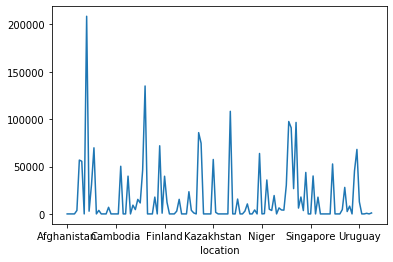

In [61]:
export_to_modeling.set_index(['time_index', 'location']).new_tests_weighted.unstack().sum().plot(legend=False)

In [62]:
export_to_modeling.shape

(18018, 24)

# Introduction <a id='intro'></a>

This notebook uses a variety of different COVID-19 related datasets to explore the behavior
of the multiple time series'. This notebook also creates new features that attempt to encapsulate the
time dependent (and time delayed) nature of the problem; these will be used during the model creation
project which makes time dependent forecasting models. 


## Exploratory Data Analysis<a id='EDA'></a>
Ideas for the inclusion or creation of new columns.

Moving averages
fourier
signal
flags for lots of different things

MI vs GA

hardest hit countries

days since

which dataset it came from

distribution of initial tests, responses, cases dates.

humans view, interpret and forecast things in a way which are not available to robots. 
data driven, time dependent manner of modeling. Really trying to encapsulate the time dependence. 

I'm electing to fill the time independent features which are ***still*** missing with the median of ***all*** current values; otherwise I would have to drop them because of the missing values. This is ok? perhaps? It's hard to justify. 



For the time dependent features, I'll fill with 0's.

Because the features I will be predicting are all measured per million people, it seems unwise to include
very small countries and microstates such as San Marino; whose small population makes them has the maximum 
value in all quantities measured "per million". In other words, I want to normalize by population but the
dynamics of these small states seems to be fundamentally different due to size.

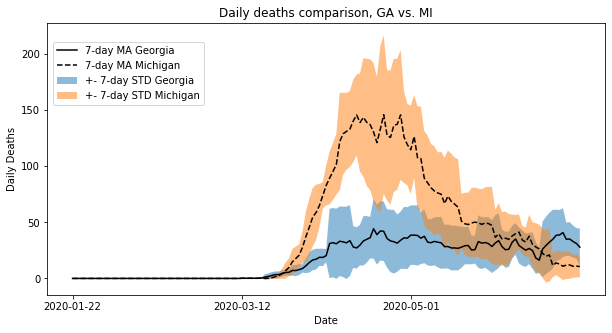

In [63]:
roll_width = 7
fig, ax = plt.subplots(figsize=(10,5))

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Georgia')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').deaths.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.5, label='+- 7-day STD Georgia')
ax.plot(range(len(pds)), rollmean, color='k', label='7-day MA Georgia')

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Michigan')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').deaths.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.5, label='+- 7-day STD Michigan')
ax.plot(range(len(pds)), rollmean, color='k',linestyle='--', label='7-day MA Michigan')

plt.legend(loc=(0.01,0.7))
plt.title('Daily deaths comparison, GA vs. MI')
_ = ax.set_ylabel('Daily Deaths')
_ = ax.set_xlabel('Date')
_ = ax.set_xticks([0, 50,100])
_ = ax.set_xticklabels(pds.index[::50])
plt.savefig('GAvsMIdeaths.jpg')

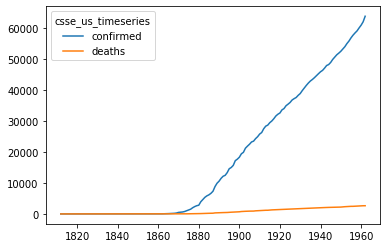

In [64]:
usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Georgia')].iloc[:, -2:].plot()


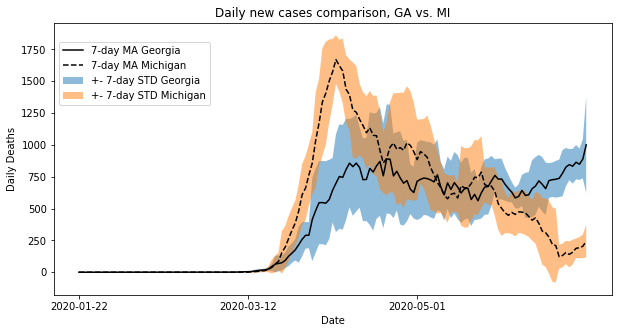

In [65]:
fig, ax = plt.subplots(figsize=(10,5))

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Georgia')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').confirmed.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.5, label='+- 7-day STD Georgia')
ax.plot(range(len(pds)), rollmean, color='k', label='7-day MA Georgia')

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Michigan')]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').confirmed.diff(1)
rollmean = pds.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std().fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.5, label='+- 7-day STD Michigan')
ax.plot(range(len(pds)), rollmean, color='k',linestyle='--', label='7-day MA Michigan')

plt.legend(loc=(0.01,0.7))
plt.title('Daily new cases comparison, GA vs. MI')
_ = ax.set_ylabel('Daily Deaths')
_ = ax.set_xlabel('Date')
_ = ax.set_xticks([0, 50,100])
_ = ax.set_xticklabels(pds.index[::50])
plt.savefig('GAvsMIcases.jpg')

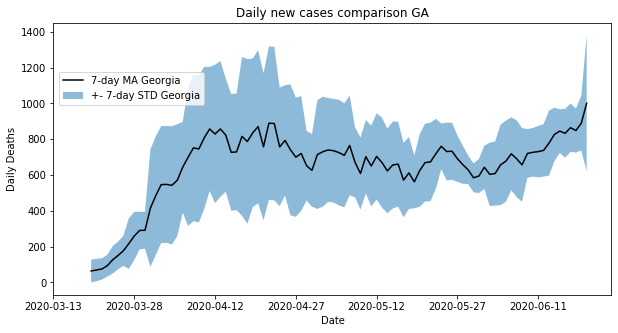

In [66]:
fig, ax = plt.subplots(figsize=(10,5))

pds = usa_time_series_df.reset_index()[(usa_time_series_df.reset_index().location=='Georgia')].iloc[-100:]
pds.loc[:, 'date'] = pds.loc[:, 'date'].dt.date
pds = pds.set_index('date').confirmed.diff(1)
rollmean = pds.rolling(roll_width).mean()#.values.ravel()#.fillna(method='backfill').values.ravel()
rollstd  = pds.rolling(roll_width).std()#values.ravel()#.fillna(method='backfill').values.ravel()
cis = (rollmean - rollstd, rollmean + rollstd)

ax.fill_between(range(len(pds)), cis[0], cis[1], alpha=0.5, label='+- 7-day STD Georgia')
ax.plot(range(len(pds)), rollmean, color='k', label='7-day MA Georgia')

plt.legend(loc=(0.01,0.7))
plt.title('Daily new cases comparison GA')
_ = ax.set_ylabel('Daily Deaths')
_ = ax.set_xlabel('Date')
_ = ax.set_xticks(list(range(0, 101, 15)))
_ = ax.set_xticklabels(pds.index[-100::15])


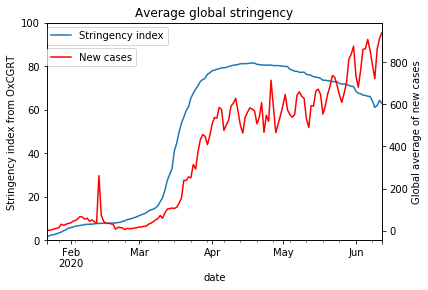

In [67]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
eda_data.groupby('date').mean().stringency_index_oxcgrt.plot(ax=ax, label='Stringency index')
eda_data.groupby('date').new_cases_owid.mean().plot(ax=ax2, color='r', label='New cases')
ax.set_ylim([0,100])
ax.set_title('Average global stringency')
ax.set_ylabel('Stringency index from OxCGRT')
ax2.set_ylabel('Global average of new cases')
ax.legend(loc=(0,0.9))
ax2.legend(loc=(0,0.8))

Is this decrease warranted? to confirm, look at the average global rate of new cases.

In [68]:
growth_rates = []
past3days = df[df.time_index >= df.time_index.max()-2]
for c in country_groupby(df):
    growth_rates.append(past3days.loc[c.intersection(past3days.index),:].new_cases_weighted.diff(1).diff(1).dropna().values[0])
growth_rates = np.array(growth_rates)
growth_rates[np.abs(growth_rates)<10**-4] = 0

In [69]:
positive_growth = 100 * (growth_rates> 0).sum() / len(growth_rates)
negative_growth =100 * (growth_rates < 0).sum() / len(growth_rates)
stationary_growth = 100 * (growth_rates==0).sum() / len(growth_rates)
print('Today, %.2f percent of countries have a positive growth rate' % positive_growth)
print('Today, %.2f percent of countries have a negative growth rate' % negative_growth)
print('Today, %.2f percent of countries have a stationary growth rate' % stationary_growth)

Today, 43.65 percent of countries have a positive growth rate
Today, 47.62 percent of countries have a negative growth rate
Today, 8.73 percent of countries have a stationary growth rate


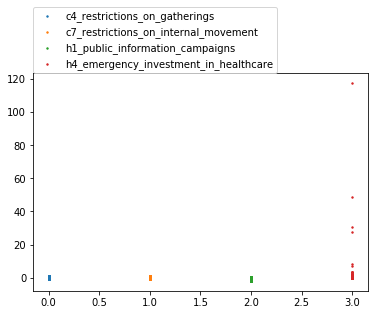

In [70]:
for i, c in enumerate(df.loc[:, column_search(df, 'n_')[:4]]):
    plt.scatter(len(df)*[i], (df.loc[:, c] - df.loc[:, c].mean()) / df.loc[:, c].std(), s=2,label=c)
plt.legend(loc=(0,1))


Time series variables with drift as baseline model : any columns with 'new' (cases, deaths, tests)
Time series variables with naive as baseline model : The complement to the drift baseline variables. 




The "Our World in Data" testing data isn't as reliable as the "Test tracker" testing data. 
This shows why it is important to be careful when selecting which representative from the
set of redundant features to use.

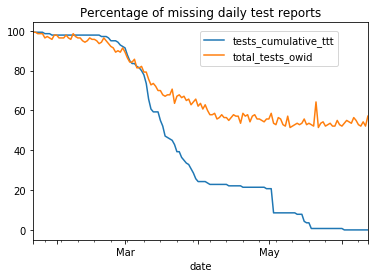

In [71]:
fig, ax = plt.subplots()
(100 * eda_data.set_index(['location', 'date']).isna().groupby(level=1).sum().loc[:, ['tests_cumulative_ttt', 'total_tests_owid']]
 / eda_data.location.nunique()).plot(ax=ax)
plt.title('Percentage of missing daily test reports')
plt.legend(loc=(0.5,0.8))
every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

Death rate estimation, assuming 50% of people are asymptomatic and do not actually get tested or confirmed.

In [72]:
today_data = df[df.time_index == df.time_index.max()]
death_rate = []
death_rate_estimation = []
for c_i in country_groupby(df):
    death_rate.append(100*df.loc[c_i,'new_deaths_weighted'].sum() / df.loc[c_i,'new_cases_weighted'].sum())
    death_rate_estimation.append(100*df.loc[c_i,'new_deaths_weighted'].sum() / (2*(df.loc[c_i,'new_cases_weighted'].sum())))

death_rate_estimation = np.array(death_rate_estimation)
death_rate = np.array(death_rate)

Likewise, the number of missing values for cases is also the worst for the OWID data set.

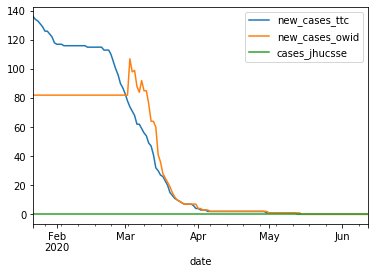

In [73]:
eda_data.loc[:,['new_cases_ttc', 'new_cases_owid','cases_jhucsse']].isna().astype(int).groupby(eda_data.date).sum().plot()

Summary statistics of the "age" of the pandemic in each country.

In [74]:
print('The statistics of the age of the pandemic in each country, in units of days.\n')
print(df[df.time_index==df.time_index.max()].days_since_first_case.describe())

The statistics of the age of the pandemic in each country, in units of days.

count    126.000000
mean     102.571429
std       20.537742
min       30.000000
25%       90.000000
50%      100.500000
75%      108.000000
max      142.000000
Name: days_since_first_case, dtype: float64


In [75]:
government_responses = pd.concat((eda_data.loc[:, ['location','time_index','days_since_first_case']],
                                  eda_data.loc[:, column_search(eda_data, 'oxcgrt')].drop(
                                      columns=column_search(eda_data, 'flag')).iloc[:,2:10]), axis=1)

In [76]:
countries_with_all_responses = None
for i, country_indices in enumerate(country_groupby(government_responses)):
    government_responses.loc[country_indices,:] = government_responses.loc[country_indices,:].fillna(method='ffill')
    has_all_flags = (government_responses.loc[country_indices,:].max() == 0).sum()
    if has_all_flags != 0:
        pass
    else:
        if countries_with_all_responses is None:
            countries_with_all_responses = government_responses.loc[country_indices,:]
        else:
            countries_with_all_responses = pd.concat((countries_with_all_responses, government_responses.loc[country_indices,:]),axis=0)

see_if_country_has_all_dates =countries_with_all_responses.groupby('location').count().sort_values(by='time_index') 
drop_these_countries = np.unique(np.where(~(see_if_country_has_all_dates == df.time_index.nunique()))[0])
countries_with_all_responses = countries_with_all_responses[~countries_with_all_responses.location.isin(drop_these_countries)]

In [77]:
pd.Index(['days_with_infection']).append(countries_with_all_responses.columns[3:])

Index(['days_with_infection', 'c1_school_closing_oxcgrt',
       'c2_workplace_closing_oxcgrt', 'c3_cancel_public_events_oxcgrt',
       'c4_restrictions_on_gatherings_oxcgrt',
       'c5_close_public_transport_oxcgrt',
       'c6_stay_at_home_requirements_oxcgrt',
       'c7_restrictions_on_internal_movement_oxcgrt',
       'c8_international_travel_controls_oxcgrt'],
      dtype='object')

In [78]:
response_ranges = []
responses = pd.Index(['active_pandemic_dates']).append(countries_with_all_responses.columns[3:])
for country_indices in country_groupby(countries_with_all_responses):
    tmp = countries_with_all_responses.loc[country_indices,:].replace(to_replace=[0,0.], value=np.nan)
    for c in tmp.columns[2:]:
        active_range = tmp.set_index('time_index').loc[:,c].dropna()
        response_ranges.append(pd.IndexSlice[int(active_range.index.min()):int(active_range.index.max()+1)])
        
response_slices_df = pd.DataFrame(np.array(response_ranges).reshape(countries_with_all_responses.location.nunique(), -1),
                                 index=countries_with_all_responses.location.unique(), columns=responses)


In [79]:
start_dates = response_slices_df.applymap(lambda x : x.start)
stop_dates = response_slices_df.applymap(lambda x : x.stop)
start_dates.columns =[x[0] for x in response_slices_df.columns.str.split('_oxcgrt')]

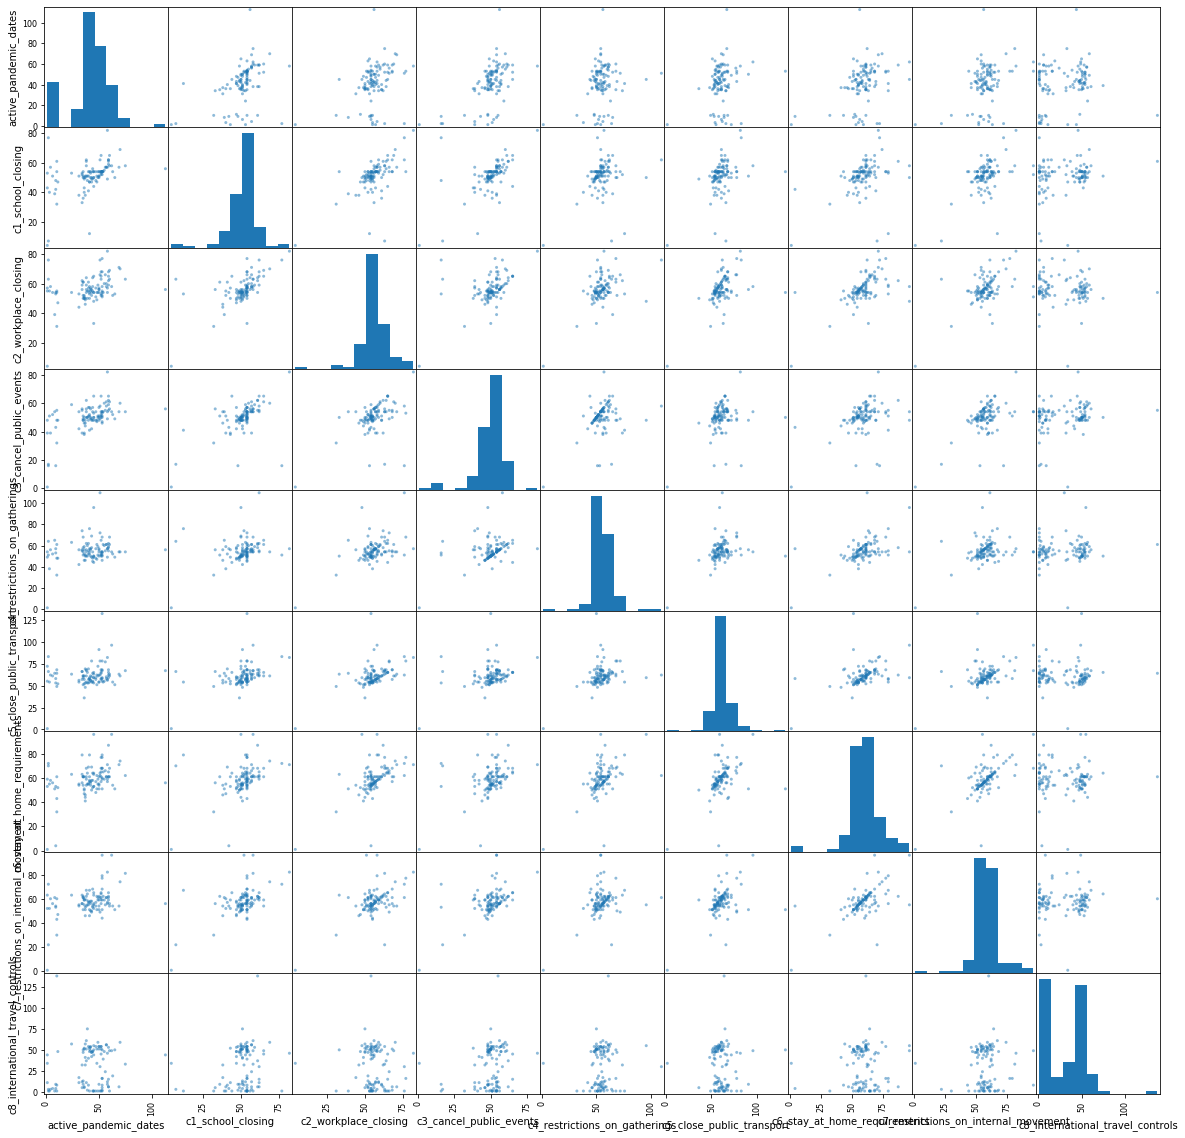

In [80]:
_ = pd.plotting.scatter_matrix(start_dates, figsize=(20,20))

In [81]:
average_response_date = response_slices_df.applymap(lambda x : x.start).iloc[:, 1:].mean(1)
average_response_date

Afghanistan      56.375
Albania          47.125
Algeria          57.500
Angola           58.000
Argentina        55.250
                  ...  
United States    44.875
Uzbekistan       55.375
Venezuela        61.500
Vietnam          39.000
Zimbabwe         54.500
Length: 104, dtype: float64

In [82]:
reaction_times = average_response_date.astype(int) - response_slices_df.applymap(lambda x : x.start).active_pandemic_dates

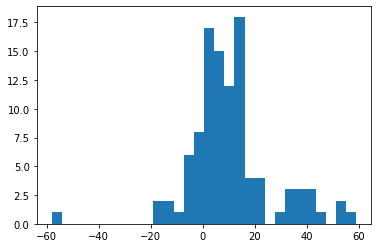

In [83]:
_ = plt.hist(reaction_times, bins=30)

In [84]:
# df[df.time_index==df.time_index.max()].total_deaths

In [85]:
death_rates = (100*df.total_deaths / df.total_cases).loc[df.time_index==df.time_index.max()].values
death_rates = pd.Series(death_rates, index=df.location.unique())
death_rates

AttributeError: 'DataFrame' object has no attribute 'total_deaths'

In [ ]:
reaction_times

In [ ]:
countries_with_all_reactions = reaction_times.index.intersection(death_rates.index)

In [ ]:
len(countries_with_all_reactions)

In [ ]:
reaction_times.loc[countries_with_all_reactions]

In [ ]:
normalized_reactions = reaction_times.loc[countries_with_all_reactions]
normalized_reactions = (normalized_reactions.values - normalized_reactions.values.mean()) / normalized_reactions.values.std()


In [ ]:
normalized_death_rates = death_rates.loc[countries_with_all_reactions]
normalized_death_rates = (normalized_death_rates - normalized_death_rates.mean()) / normalized_death_rates.std()

In [ ]:
len(normalized_reactions)

In [ ]:
normalized_death_rates

In [ ]:
len(countries_with_all_reactions)

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(normalized_reactions, normalized_death_rates)

fig, ax = plt.subplots()
ax.scatter(normalized_reactions, 
            normalized_death_rates)
ax.plot(np.arange(-5,5), slope*np.arange(-5,5) + intercept, color='r')
ax.set_ylim([-4, 4])
ax.set_xlim([-4, 4])
ax.set_title('Death rate vs. reaction time')
ax.grid(True)

In [ ]:
slope, intercept, r_value, p_value, std_err 

Late responders, first government action AFTER first case.

Early responders, first government action BEFORE first case.

In [ ]:
first_day_responses_sum = countries_with_all_responses[countries_with_all_responses.days_since_first_case == 1].iloc[:, 3:].sum(axis=1)

In [ ]:
countries_with_all_reactions

In [ ]:
countries_with_all_responses

In [ ]:
dates_of_first_responses = countries_with_all_responses[(countries_with_all_responses.location.isin(countries_with_all_reactions))&(countries_with_all_responses.days_since_first_case == 1)].time_index

In [ ]:
dates_of_first_responses

In [ ]:
countries_with_all_responses.location.nunique()

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(reaction_times.loc[countries_with_all_reactions],death_rates.loc[countries_with_all_reactions])

plt.scatter(dates_of_first_responses, 
            death_rates.loc[countries_with_all_reactions])
plt.plot(np.arange(-60,100), slope*np.arange(-60,100) + intercept, color='r') 
plt.title('Death rate vs. reaction time')
print(slope, intercept, r_value, p_value, std_err)

In [ ]:
early_responders_args = first_day_responses_sum[first_day_responses_sum > 0].index
early_responders = countries_with_all_responses.loc[early_responders_args,:].location.values
print('\n The early responders:\n')
print(early_responders)

In [ ]:
late_responders_args = first_day_responses_sum[first_day_responses_sum == 0].index
late_responders = countries_with_all_responses.loc[late_responders_args,:].location.values
print('The late responders:\n')
print(late_responders)

In [ ]:
late_df = df[df.location.isin(late_responders)]
early_df = df[df.location.isin(early_responders)]

In [ ]:
early_df_present_day = early_df[early_df.time_index == df.time_index.max()]
late_df_present_day = late_df[late_df.time_index == df.time_index.max()]

In [ ]:
d_rate = pd.Series(death_rates, index=df.location.unique())

In [ ]:
early_d_rates = d_rate.loc[early_df_present_day.location.unique()]
late_d_rates = d_rate.loc[late_df_present_day.location.unique()]

In [ ]:
_ = plt.scatter(early_d_rates, early_df_present_day.total_cases.values, label='Early responders')
_ = plt.scatter(late_d_rates, late_df_present_day.total_cases.values, label='Late responders')
_ = plt.xlabel('Estimated death rate, (% of total cases)')
_ = plt.ylabel('Number of cases per million people')
_ = plt.legend(loc=(0.6,0.2))
_ = plt.yscale('log')
# plt.plot(np.sort(death_rate))

Does not seem to be any obvious partition between early and late responders.

In [ ]:
dftmp = pd.concat((df, (df.total_deaths / df.total_cases).to_frame(name='death_rates')),axis=1)
xcr = dftmp.corr()

In [ ]:
xcr.loc['death_rates',:].sort_values()

In [ ]:
# m1_wildcard (-1) is nan, -2 is deaths rates.
xcr.loc['death_rates',:].sort_values()[:-2].plot.hist()

In [ ]:
ncountrylist = []
for n in range(df.time_index.min(), df.time_index.max()+1):
    ncountrylist.append((df.location.nunique()-df[df.days_since_first_case > n].location.nunique()))
plt.plot(df.date.unique(), ncountrylist)
plt.ylim([0, df.location.nunique()+1])
plt.title('')
plt.ylabel('Number of infected countries')
plt.xlabel('Date')
_ = plt.show()

In [ ]:
ncountrylist = []
for n in range(0, df.time_index.nunique()):
    ncountrylist.append(100*(df.location.nunique()-df[df.days_since_first_case > n].location.nunique())/df.location.nunique())
plt.plot(df.date.unique(), ncountrylist)
plt.ylim([0, 100])
plt.title('Number of reporting countries with cases')
plt.ylabel('Percentage of countries')
plt.xlabel('Date')
_ = plt.show()

In [ ]:
maxima_of_new_cases_weighted_series

In [ ]:
dftmp.location.nunique()

In [ ]:
df.groupby('date').mean().new_cases_weighted.plot()

In [ ]:
dftmp = df[df.time_index >= 40]
dftmp = dftmp[dftmp.location.isin(dftmp[dftmp.days_since_first_case > 60].location.unique())]
maxima_of_new_cases_weighted_series = dftmp.set_index(['time_index','location']).new_cases_weighted.unstack().max().sort_values().index
dftmp.set_index(['time_index','location']).loc[pd.IndexSlice[:, maxima_of_new_cases_weighted_series],:].new_cases_weighted.unstack().plot(legend=False,figsize=(10,10))
# plt.legend(loc=(1,0))

